# 3-hour kaggle challenge
# Animal shelter

The objective is to predict the outcome for an animal coming into the shelter 

In this competition, you are going to predict the outcome of the animal as they leave the Animal Center. These **outcomes include: Adoption, Died, Euthanasia, Return to owner, and Transfer**. 

In [1]:
from __future__ import print_function, division


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import timeit


In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


## Approach:

Clean the data set and use the following Classification models to build models:  Logistic regression, Random Forrest, Gradient boosting; then use Cross validation on the best model 

**Remember the objective is to increase overall Accuracy, not any other evaluation **

### Features
1. Age:
    1. convert all to weeks
1. Sex:
    1. seperate out Spayed/Neutered and M/F 
 1. Animal Type:
     1. Cat / Dog 

#### to be added if time left 
1. Breed
1. Outcome subtype
1. Color
    

In [4]:
"""
    Total amount of animals
"""

df.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.0+ MB


In [6]:
df_all_distribution = df.groupby('OutcomeType')['AnimalID'].count().reset_index().sort_values('OutcomeType',ascending=False)

#cleaning/renaming
df_all_distribution.rename(columns={'AnimalID':'Count'},inplace=True)
df_all_distribution.sort_values('Count', ascending=False, inplace=True)

In [7]:
df_all_distribution

,OutcomeType,Count
0,Adoption,10769
4,Transfer,9422
3,Return_to_owner,4786
2,Euthanasia,1555
1,Died,197


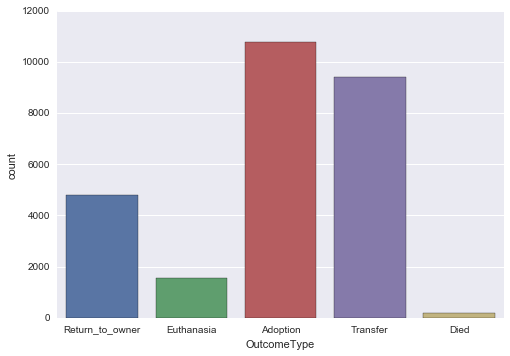

In [8]:
#df_all_distribution

ax = sns.countplot(x="OutcomeType", data=df)

# Analyzing the sex


In [9]:
df.SexuponOutcome.unique()

array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Unknown', nan], dtype=object)

Sex: how many were unkonwn/nan?

In [10]:
df.SexuponOutcome.describe()

count             26728
unique                5
top       Neutered Male
freq               9779
Name: SexuponOutcome, dtype: object

In [11]:
df.groupby('SexuponOutcome')[['AnimalID']].count().reset_index()

,SexuponOutcome,AnimalID
0,Intact Female,3511
1,Intact Male,3525
2,Neutered Male,9779
3,Spayed Female,8820
4,Unknown,1093


In [12]:
#df[df.SexuponOutcome==None]

df[df.SexuponOutcome.isnull()]

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
3174,A667395,Diego,2013-11-27 16:11:00,Return_to_owner,NaN,Dog,NaN,7 years,Dachshund,Brown Merle


##### there's just one, so we can delete the value

In [13]:
# index of the value to delete
#index_of_nanSex = df[df.SexuponOutcome.isnull()].index
#
df = df.loc[df.SexuponOutcome.notnull()]

In [14]:
# unkown 

df.loc[df.SexuponOutcome=='Unknown'].count()

AnimalID          1093
Name                37
DateTime          1093
OutcomeType       1093
OutcomeSubtype    1076
AnimalType        1093
SexuponOutcome    1093
AgeuponOutcome    1089
Breed             1093
Color             1093
dtype: int64

##### this one is trickier

so whilethere is just one nan, there are thousands unknown Sex animals, let's look at their distribution of Outcomes 

In [15]:
unknownSexoutcomes = df.loc[df.SexuponOutcome=='Unknown']['OutcomeType']

df_unknownSex = df.loc[df.SexuponOutcome=='Unknown']

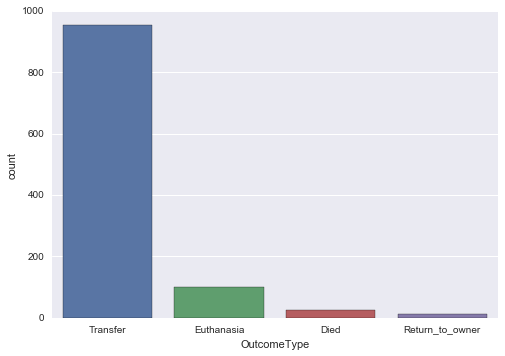

In [16]:
ax = sns.countplot(x='OutcomeType' , data=df_unknownSex )

**none were adopted **; It appears as though unkonwns get mostly transferred. 
Maybe they were in the shelter only a short time, too short for the shelter to record the Sex? 

It seems like a good idea to leave it in. 

##### how to seperate out Sex:
1. create 3 columns 
1. One for just sex: M/F
1. One for just reproductiveState: Spayed/Neutered or Intact : for simplicity call all Spayed+Neutered =  Neutered 
1. One for unkonwn
1. leave the combined column 

In [17]:
df[:3]

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White


In [18]:
df['SexuponOutcome'].apply(lambda x: x.split())[0][1]

'Male'

In [19]:
df['reproductive_state'], df['Sex'] = df['SexuponOutcome'].str.split(' ', ).str

In [20]:
df[:3]

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,reproductive_state,Sex
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,Neutered,Male
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,Spayed,Female
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,Neutered,Male


In [21]:
#convert to categorical
df.reproductive_state.dtype

dtype('O')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26728 entries, 0 to 26728
Data columns (total 12 columns):
AnimalID              26728 non-null object
Name                  19037 non-null object
DateTime              26728 non-null object
OutcomeType           26728 non-null object
OutcomeSubtype        13117 non-null object
AnimalType            26728 non-null object
SexuponOutcome        26728 non-null object
AgeuponOutcome        26710 non-null object
Breed                 26728 non-null object
Color                 26728 non-null object
reproductive_state    26728 non-null object
Sex                   25635 non-null object
dtypes: object(12)
memory usage: 2.7+ MB


#### Age fixing: 

In [23]:
df.AgeuponOutcome.unique()

array(['1 year', '2 years', '3 weeks', '1 month', '5 months', '4 years',
       '3 months', '2 weeks', '2 months', '10 months', '6 months',
       '5 years', '7 years', '3 years', '4 months', '12 years', '9 years',
       '6 years', '1 weeks', '11 years', '4 weeks', '7 months', '8 years',
       '11 months', '4 days', '9 months', '8 months', '15 years',
       '10 years', '1 week', '0 years', '14 years', '3 days', '6 days',
       '5 days', '5 weeks', '2 days', '16 years', '1 day', '13 years',
       nan, '17 years', '18 years', '19 years', '20 years'], dtype=object)

In [47]:
df.groupby('AgeuponOutcome')[['AnimalID']].count().reset_index().sort_values('AnimalID', ascending=False)

,AgeuponOutcome,AnimalID
5,1 year,3969
21,2 years,3742
19,2 months,3397
26,3 years,1823
2,1 month,1281
24,3 months,1277
30,4 years,1071
34,5 years,992
28,4 months,888
37,6 years,670


In [24]:
### how many missing? 

df[df.AgeuponOutcome.isnull()].count()

AnimalID              18
Name                   0
DateTime              18
OutcomeType           18
OutcomeSubtype        18
AnimalType            18
SexuponOutcome        18
AgeuponOutcome         0
Breed                 18
Color                 18
reproductive_state    18
Sex                   14
dtype: int64

In [25]:
df[df.AgeuponOutcome=='0 years'].count()

AnimalID              22
Name                   0
DateTime              22
OutcomeType           22
OutcomeSubtype        22
AnimalType            22
SexuponOutcome        22
AgeuponOutcome        22
Breed                 22
Color                 22
reproductive_state    22
Sex                    9
dtype: int64

#### we have 18 animals who do not have an Age estimate.
        for the sake of moving along, cut it out
        
#### what about the 0 years? I don't know if that means 52 weeks (not yet 1 year) or less than 52 weeks?

In [26]:
# remove null values
df = df[df.AgeuponOutcome.notnull()]

In [27]:
df[:3]

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,reproductive_state,Sex
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,Neutered,Male
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,Spayed,Female
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,Neutered,Male


In [28]:
df.AgeuponOutcome.dtype

dtype('O')

In [29]:
"""
    AgeuponOutcome is an object, convert to string, split and then into weeks
"""
#df.loc[:,'AgeuponOutcome']
df['AgeuponOutcome']= df.loc[:,'AgeuponOutcome'].astype('|S80')

In [30]:
df.AgeuponOutcome.dtype
df.dtypes ### ?

AnimalID              object
Name                  object
DateTime              object
OutcomeType           object
OutcomeSubtype        object
AnimalType            object
SexuponOutcome        object
AgeuponOutcome        object
Breed                 object
Color                 object
reproductive_state    object
Sex                   object
dtype: object

In [31]:
df['AgeuponOutcome'].str.split(' ', 1)[2]

['2', 'years']

## convert to days

In [48]:
"""
    return number of DAYS
    there are plural values of 'week', 'day', 'month' and 'years'
    if animal is less than a week old return 0
"""
def convert_to_days(s):
        
        num, val = s.split(' ', 1)
        num = int(num)
        #print (num)
        #print (val)
        if "week" in val:
            return num*7 
        elif "year" in val: 
            return num*356
        elif "day" in val:
            return num
        elif "month" in val:
            return num*30


In [33]:
convert_to_days(df['AgeuponOutcome'][2])

104

In [49]:
#test days returns ok
df[df['AgeuponOutcome']=='5 days']
df['AgeuponOutcome'][473]
convert_to_days(df['AgeuponOutcome'][473])

5

##### forgot to resolve months

In [51]:
"""
    apply this to the entire Age column
"""
df['Age_in_days'] = df['AgeuponOutcome'].apply(lambda x: convert_to_days(x))
#df[:10]

In [52]:
df[:3]

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,reproductive_state,Sex,Age_in_days
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,Neutered,Male,356
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,Spayed,Female,356
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,Neutered,Male,712


# One hot encoding : I'm going to use Label encoding 

1. Outcomes:
    1. adopted = 
    2. transferred = 
    3. died = 
    4. euthanisia
    5. return to owner
2. Sex/Reproductive state
3. Sex
4. Reproductive state
    1. Neutered
    2. Intact
    3. Unknown 
5. Animal Type dog/cat
    
    

Use **pd.get_dummies()** once you finish all the data cleaning 

In [99]:
columns = ['OutcomeType','AnimalType','SexuponOutcome','reproductive_state', 'Sex', 'Age_in_days']

df_model = df.loc[:,columns]

In [100]:
df_model[:3]
df_model.shape

(26710, 6)

In [101]:
"""
    Animal Type
"""
type_dummy = pd.get_dummies(df.AnimalType)
type_dummy.shape

(26710, 2)

In [102]:
df_model = df_model.join(type_dummy)
df_model[:3]

,OutcomeType,AnimalType,SexuponOutcome,reproductive_state,Sex,Age_in_days,Cat,Dog
0,Return_to_owner,Dog,Neutered Male,Neutered,Male,356,0.0,1.0
1,Euthanasia,Cat,Spayed Female,Spayed,Female,356,1.0,0.0
2,Adoption,Dog,Neutered Male,Neutered,Male,712,0.0,1.0


In [160]:
df_model.Sex.unique()

array(['Male', 'Female', nan], dtype=object)

In [168]:
df_model.loc[df_model['Sex'].isnull(),'Sex'] = 'Unknown' 

In [169]:
df_model.Sex.unique()

array(['Male', 'Female', 'Unknown'], dtype=object)

In [174]:
""" Sex, reproductive_state """
Sex_dummy = pd.get_dummies(df.Sex)
reproductive_dummy = pd.get_dummies(df.reproductive_state)
combo_sex_reproductive = pd.get_dummies(df.SexuponOutcome)

#df_model = df_model.join(Sex_dummy)
#df_model = df_model.join(reproductive_dummy)
#df_model = df_model.join(combo_sex_reproductive)

In [175]:
#df_model = df_model.join(combo_sex_reproductive)
combo_sex_reproductive.drop('Unknown', axis=1, inplace=True)
combo_sex_reproductive[:3]

,Intact Female,Intact Male,Neutered Male,Spayed Female
0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0


In [177]:
#df_model = df_model.join(combo_sex_reproductive)
df_model[:3]

,OutcomeType,AnimalType,SexuponOutcome,reproductive_state,Sex,Age_in_days,Cat,Dog,Intact Female,Intact Male,Neutered Male,Spayed Female,Female,Male,Intact,Neutered,Spayed,Unknown
0,0,Dog,Neutered Male,Neutered,Male,356,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,4,Cat,Spayed Female,Spayed,Female,356,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,Dog,Neutered Male,Neutered,Male,712,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [178]:
df_model.OutcomeType.unique()

array([0, 4, 1, 2, 3])

In [ ]:
'Return_to_owner','Adoption', 'Transfer','Died','Euthanasia'

In [107]:
def convert_outcome(s):
    if s == 'Return_to_owner':
        return 0
    elif s == 'Adoption':
        return 1
    elif s == 'Transfer':
        return 2
    elif s == 'Died':
        return 3 
    elif s == 'Euthanasia':
        return 4

In [108]:
df_model.OutcomeType[33]

'Return_to_owner'

In [109]:
convert_outcome(df_model.OutcomeType[33])

0

In [110]:

df_model['OutcomeType'] = df_model['OutcomeType'].apply(lambda x: convert_outcome(x))

In [141]:
df_model[:3]

,OutcomeType,AnimalType,SexuponOutcome,reproductive_state,Sex,Age_in_days,Cat,Dog,Intact Female,Intact Male,Neutered Male,Spayed Female
0,0,Dog,Neutered Male,Neutered,Male,356,0.0,1.0,0.0,0.0,1.0,0.0
1,4,Cat,Spayed Female,Spayed,Female,356,1.0,0.0,0.0,0.0,0.0,1.0
2,1,Dog,Neutered Male,Neutered,Male,712,0.0,1.0,0.0,0.0,1.0,0.0


array(['Male', 'Female', nan], dtype=object)

In [115]:
df_model.columns

Index([u'OutcomeType', u'AnimalType', u'SexuponOutcome', u'reproductive_state',
       u'Sex', u'Age_in_days', u'Cat', u'Dog', u'Intact Female',
       u'Intact Male', u'Neutered Male', u'Spayed Female'],
      dtype='object')

In [140]:
#df_model.isnull().values.
df_model[pd.isnull(df_model).any(axis=1)][:3]

,OutcomeType,AnimalType,SexuponOutcome,reproductive_state,Sex,Age_in_days,Cat,Dog,Intact Female,Intact Male,Neutered Male,Spayed Female
7,2,Cat,Unknown,Unknown,NaN,21,1.0,0.0,0.0,0.0,0.0,0.0
10,2,Cat,Unknown,Unknown,NaN,712,1.0,0.0,0.0,0.0,0.0,0.0
64,2,Cat,Unknown,Unknown,NaN,14,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
"""
    replace 'Sex ==Nan" with Unknown
"""

In [179]:
df_model.columns;
columns = ['Age_in_days', 'Cat', 'Dog', 'Female', 'Male','Intact',
       'Neutered', 'Spayed', 'Unknown', 'Intact Female', 'Intact Male',
       'Neutered Male', 'Spayed Female']

X = df_model.loc[:,columns]
y = df_model.loc[:,'OutcomeType']

removed all NaN's 
see above in the "Female/Male" section; replaced all NaN's with "Unknown"

In [202]:
#y

In [181]:
X[pd.isnull(X).any(axis=1)].shape

(0, 13)

# step 5. Modeling 

In [238]:

from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, log_loss

from sklearn.metrics import confusion_matrix

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=4444 )

In [184]:
"""
    make an instance of a Logistic Regression Model 
"""

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [212]:
"""
    predict outcome; not probabilities
"""
y_pred = lr_model.fit(X_train, y_train).predict(X_test)


In [218]:
y_pred


array([2, 0, 1, ..., 1, 1, 1])

In [197]:
"""prediction : use predict_proba to get the probabilities""" 
prediction = lr_model.fit(X_train, y_train).predict_proba(X_test)


##### prediction is the probabilities of outcome for each row in X_test

In [204]:
prediction.shape

(8013, 5)

In [205]:
prediction

array([[0.02567402, 0.06431928, 0.79157821, 0.0203611 , 0.09806739],
       [0.36245106, 0.00347403, 0.35952055, 0.00972109, 0.26483327],
       [0.2575521 , 0.53218229, 0.18242178, 0.00141663, 0.0264272 ],
       ...,
       [0.2575521 , 0.53218229, 0.18242178, 0.00141663, 0.0264272 ],
       [0.21790051, 0.57467824, 0.18467833, 0.00134752, 0.02139539],
       [0.03008314, 0.71113164, 0.24197079, 0.00376579, 0.01304864]])

In [ ]:
pred_vec = prediction[:,1]

In [192]:
"""
    Log-loss
"""
log_loss(y_test, y_pred_lr) #make sure have prediction variable 

0.9440608894072384

In [203]:
#accuracy_score(y_test, prediction, normalize=True)

In [210]:
y_test[:3]

17986    2
2343     0
24305    0
Name: OutcomeType, dtype: int64

In [219]:
from sklearn.metrics import classification_report

target_names = ['Return_to_owner','Adoption', 'Transfer','Died','Euthanasia']
print(classification_report(y_test, y_pred, target_names=target_names))

                 precision    recall  f1-score   support

Return_to_owner       0.49      0.27      0.35      1508
       Adoption       0.60      0.90      0.72      3190
       Transfer       0.74      0.63      0.68      2782
           Died       0.00      0.00      0.00        62
     Euthanasia       1.00      0.00      0.00       471

    avg / total       0.65      0.63      0.59      8013



/Users/billierolih/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [222]:
"""
    what about accuracy? 
"""
accuracy = accuracy_score(y_test, y_pred, normalize=True)
accuracy

0.6297266941220516

## Random forest classifier
can we do better with a random forest classifier? 

In [230]:
rnd = RandomForestClassifier(n_estimators=900, max_features='sqrt', n_jobs=-1)
y_pred_RF_P = rnd.fit(X_train, y_train).predict(X_test)

In [231]:
accuracy_score(y_test, y_pred_RF_P, normalize=True)

0.6344689878946712

In [240]:
rnd.feature_importances_

array([0.41862435, 0.04185494, 0.04134761, 0.00991653, 0.01885662,
       0.17619855, 0.04402416, 0.02811937, 0.04319966, 0.05801247,
       0.05194991, 0.03712588, 0.03076994])

In [232]:
target_names = ['Return_to_owner','Adoption', 'Transfer','Died','Euthanasia']
print(classification_report(y_test, y_pred_RF_P, target_names=target_names))

                 precision    recall  f1-score   support

Return_to_owner       0.47      0.44      0.45      1508
       Adoption       0.65      0.80      0.72      3190
       Transfer       0.71      0.65      0.68      2782
           Died       0.00      0.00      0.00        62
     Euthanasia       0.47      0.08      0.14       471

    avg / total       0.62      0.63      0.62      8013



# Gradient Boosting Classifier

In [233]:
model_gb1 = GradientBoostingClassifier(n_estimators=4000,max_depth=3,learning_rate=.003)
model_gb1.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.003, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=4000, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [235]:
# predict class labels for the test set
gb1_pred_mat = model_gb1.predict(X_test)
#gb1_pred_vec = gb1_pred_mat[:,1]

In [236]:
accuracy_score(y_test, gb1_pred_mat, normalize=True)

0.6360913515537252

In [237]:
target_names = ['Return_to_owner','Adoption', 'Transfer','Died','Euthanasia']
print(classification_report(y_test, gb1_pred_mat, target_names=target_names))

                 precision    recall  f1-score   support

Return_to_owner       0.47      0.44      0.46      1508
       Adoption       0.65      0.80      0.72      3190
       Transfer       0.71      0.66      0.69      2782
           Died       0.00      0.00      0.00        62
     Euthanasia       0.51      0.07      0.12       471

    avg / total       0.62      0.64      0.62      8013



In [251]:
target_names

['Return_to_owner', 'Adoption', 'Transfer', 'Died', 'Euthanasia']

In [249]:
### Confusion matrix

cm = confusion_matrix(y_test, gb1_pred_mat)

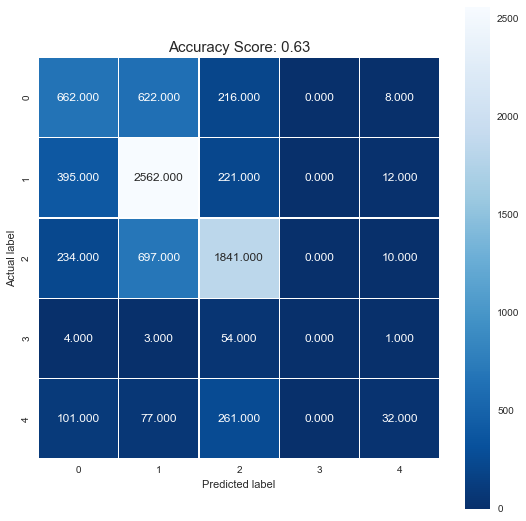

In [250]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(accuracy,2))
plt.title(all_sample_title, size = 15);

In [242]:
a = list(zip(X.columns, model_gb1.feature_importances_))

In [243]:
a.sort(key=lambda tup: tup[1]) 
a

[('Neutered Male', 0.006190722879981095),
 ('Neutered', 0.006422847628341332),
 ('Male', 0.010087780234875525),
 ('Spayed', 0.012134831648600982),
 ('Spayed Female', 0.012594042117215654),
 ('Female', 0.012879491552812419),
 ('Intact Male', 0.027367250037282968),
 ('Intact Female', 0.031622331608738945),
 ('Unknown', 0.046588854602789095),
 ('Intact', 0.07212464658084126),
 ('Cat', 0.09542254325255001),
 ('Dog', 0.09617884089257579),
 ('Age_in_days', 0.5703858169633949)]